# **Business Objective: Predicting 1980s Hit Songs**

The 1980s was a transformative time period in history, as reflected in the diversity of the music. Many memorable hit songs came from that decade. Here, we predict 80s hits based on [song features](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/) using classification models: **Logistic Regression, K-Nearest Neighbor, Support Vector Machine (SVM), Kernel SVM, Naive Bayes, Artificial Neural Network, Decision Tree, Random Forest, and XGBoost**. We then determine which model is the most accurate.

## Import the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Import the dataset

Please go [here](https://www.kaggle.com/theoverman/the-spotify-hit-predictor-dataset) for the dataset description

In [2]:
dataset = pd.read_csv('dataset-of-80s.csv')
X = dataset.iloc[:, 3:-1].values
y = dataset.iloc[:, -1].values

In [3]:
dataset.shape

(6908, 19)

In [4]:
dataset.head(10)

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target
0,Walking Blues,Big Joe Williams,spotify:track:1ZjN5X8LmUB67pWPgimW3B,0.509,0.277,6,-14.323,1,0.0495,0.827000,0.002060,0.0756,0.640,101.157,161893,4,68.46530,7,0
1,Suddenly Last Summer,The Motels,spotify:track:4fLIM0B1WwrLux9RdnMvze,0.716,0.753,2,-5.682,1,0.0286,0.162000,0.030600,0.0831,0.561,120.141,222000,4,57.71583,11,1
2,Sanctuary,Béla Fleck,spotify:track:3DwlNfiCQSdj0GOxYkR9Rq,0.360,0.542,5,-13.885,1,0.0339,0.368000,0.165000,0.1160,0.803,116.831,444907,4,30.34574,17,0
3,The Wild Rover,The Pogues,spotify:track:6JyYNPLalPgGa7XnclF5FO,0.656,0.512,7,-11.872,1,0.0290,0.585000,0.000000,0.0720,0.880,97.500,157893,3,50.97022,7,0
4,In The Driver's Seat,John Schneider,spotify:track:6jJi8OXF5qaFdysB6sjWIT,0.642,0.889,2,-5.620,0,0.0494,0.375000,0.000000,0.1800,0.764,163.351,162293,4,33.62053,7,1
5,Slow Kill,Fields Of The Nephilim,spotify:track:3AKzRH32S4Jc5Ge4RFp5WG,0.296,0.547,4,-15.115,0,0.0327,0.000291,0.013600,0.3720,0.490,148.775,224360,4,53.02555,11,0
6,Young Wild And Free,Brighton Rock,spotify:track:7EBpncUwlHjLhQTetSLb9O,0.454,0.734,2,-15.559,1,0.0410,0.124000,0.000014,0.0990,0.460,135.527,225560,4,36.52688,11,0
7,Holiday,The Other Ones,spotify:track:3f1rbdXIbz36QZ8xU7wt2i,0.487,0.853,11,-10.165,0,0.0343,0.027700,0.007370,0.1360,0.802,83.593,213427,4,15.23401,10,1
8,Answering Machine,Rupert Holmes,spotify:track:5Qo14bQqTK9iGbf2g6JUjL,0.775,0.488,0,-15.044,1,0.1230,0.240000,0.000000,0.0368,0.961,81.158,215200,4,28.65643,9,1
9,Crystal Ball,Yngwie Malmsteen,spotify:track:6C3BPDXuHFRbCWsTk4eNPU,0.406,0.777,8,-11.498,1,0.0590,0.087000,0.000016,0.1960,0.456,131.109,295507,4,41.44096,12,0


**Note:** We are excluding Track and Artist as Features to consider in our model. Artist is a '20/20 hindsight' observation since, looking back, we already know which artists dominated the 1980s. This will greatly, but artificially, increase the model accuracy and is akin to data leakage. If our goal is to look in the rearview mirror to see how the Predicted Hits stack up to Actual Hits, we would include Artist feature in our model. However, the goal is to predict hits in real-time when singles have just been released. So, in the moment, we do not yet know or have the historical perspective about which artists have or will achieve greatness.

## ***Data Preprocessing***

## Check for Null Values

In [5]:
null_count = dataset.isnull().sum()
null_pct = ((dataset.isnull().sum())/(dataset.isnull().count()))*100
null_type = dataset.dtypes
missing_data = pd.concat([null_count, null_pct, null_type], axis = 1, keys = ['Null Values', 'Percent of Total', 'Data Type'])
missing_data = missing_data.sort_values(by = 'Percent of Total', ascending = False).round(2)
missing_data

,Null Values,Percent of Total,Data Type
track,0,0.0,object
instrumentalness,0,0.0,float64
sections,0,0.0,int64
chorus_hit,0,0.0,float64
time_signature,0,0.0,int64
duration_ms,0,0.0,int64
tempo,0,0.0,float64
valence,0,0.0,float64
liveness,0,0.0,float64
acousticness,0,0.0,float64


No null values are present

## Determine Feature Correlations

In [6]:
def make_corr_map(df, title='Correlation Heat Map', size=(9,7)):
    corr = df.corr()
    mask = np.triu(np.ones_like(corr)) # for upper triangle
    f, ax = plt.subplots(figsize=size)
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title(title)


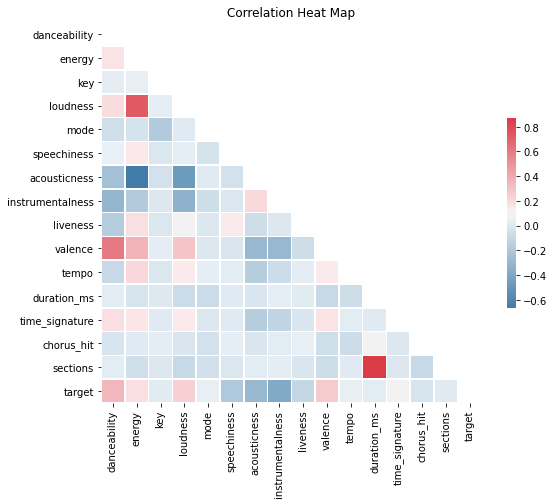

In [7]:
make_corr_map(dataset)

Energy seems highly correlated to loudness, while duration_ms is correlated to sections. We will select features more rigorously using established methods.

## Encode categorical data

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Column order for Tree model
feat_tree = [i for i in dataset.columns]
feat_tree = feat_tree[3:18]

# OneHotEncode key, time_signature, and sections features for all models except for Naive Bayes and Tree models
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(sparse=False), [2,12,14])], remainder='passthrough')
X_nt = np.array(ct.fit_transform(X))

# Column order for non-Tree model
feat_nt = ['Key', 'Time_Sig', 'Sections', 'Danceability', 'Energy', 'Loudness', 'Mode', 'Speechiness',
            'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_ms', 'Chorus_hit']

## Feature scaling for non-Tree models

In [9]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_nt_sc = sc.fit_transform(X_nt)

## Split the dataset into the Training set and Test set

In [10]:
from sklearn.model_selection import train_test_split
# For Non-Tree models
X_train_nt, X_test_nt, y_train, y_test = train_test_split(X_nt_sc, y, test_size = 0.25, random_state = 42)
# For Naive Bayes and Tree models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

## ***Non-Tree-Based Algorithms***

## *Logistic Regression with Feature Selection*

## Feature Selection using Logistic Regression with L1 penalty (similar to LassoCV)
*   This method penalizes coefficients of variables by shrinking (regularizing) them - some to zero
*   *Feature Selection* - Non-zero coefficients are selected to be part of the model
*   Requires model (relationship between X and y) for selection analysis

In [11]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(penalty='l1', solver='liblinear')
log.fit(X_train_nt, y_train)

importance = np.abs(log.coef_)

# Sum Coef's for Key (Categorical)
feat_key = np.array(importance[0,0:12].sum())
# Sum Coef's for Time_Signature (Categorical)
feat_time = np.array(importance[0,12:16].sum())
# Sum Coef's for Sections (Categorical)
feat_sec = np.array(importance[0,16:67].sum())

feat_rest = np.array(importance[0,67:])

# Gather coef values for Key, Time Signature, Sections, Artists, and rest of features
feat_hits = np.append(feat_key, feat_time)
feat_hits = np.append(feat_hits, feat_sec)
feat_hits = np.append(feat_hits, feat_rest)

feat_sig = pd.DataFrame(zip(feat_nt, feat_hits))
feat_sig.columns = ['Feature', 'Coef']
feat_sig = feat_sig.sort_values('Coef', ascending=False)
feat_sig = feat_sig.reset_index(drop=True)
feat_sig.index += 1 
feat_sig

,Feature,Coef
1,Sections,4.683949
2,Instrumentalness,1.145342
3,Speechiness,0.887362
4,Danceability,0.717441
5,Acousticness,0.577000
6,Loudness,0.492778
7,Duration_ms,0.483880
8,Key,0.312536
9,Energy,0.211812
10,Time_Sig,0.204577


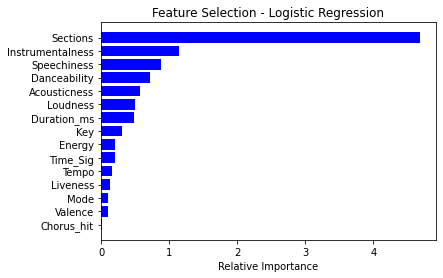

In [12]:
indices = np.argsort(feat_hits)
plt.title('Feature Selection - Logistic Regression')
plt.barh(range(len(indices)), feat_hits[indices], color='b', align='center')
plt.yticks(range(len(indices)), np.array(feat_nt)[indices])
plt.xlabel('Relative Importance')

plt.show()

We will keep all Features in this model. Note that instrumentalness, speechiness, danceability, and acousticness are at the top of the list. The importance of this group of features reappears in the performance of other models shown below.

## Train the Logistic Regression model on the Training set

In [13]:
from sklearn.linear_model import LogisticRegression
log_class = LogisticRegression(random_state = 42)
log_class.fit(X_train_nt, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Logistic Regression k-folds Cross Validation

In [14]:
from sklearn.model_selection import cross_val_score
log_acc = cross_val_score(estimator = log_class, X = X_nt_sc, y = y, cv = 10, scoring = 'accuracy')
print('Accuracy Mean:', log_acc.mean(), '\nAccuracy SD:', log_acc.std())

cvacc = []
cvacc_std = []
cvacc.append(round(log_acc.mean(), 4))
cvacc_std.append(round(log_acc.std(), 4))

Accuracy Mean: 0.7744610834958787 
Accuracy SD: 0.012583338691727088


## Predict the Test set Results

In [15]:
y_pred_log = log_class.predict(X_test_nt)

## Make the Logistic Regression Confusion Matrix

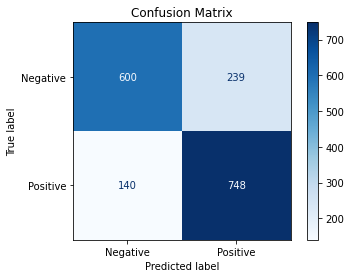

In [16]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, plot_confusion_matrix
class_names = np.array(['Negative', 'Positive'])
title = 'Confusion Matrix'
disp = plot_confusion_matrix(log_class, X_test_nt, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             values_format='d')
disp.ax_.set_title(title)
plt.show()

In [17]:
test_acc = []
test_acc.append(round((accuracy_score(y_test, y_pred_log)*100),2))
print('The accuracy score is {}%'.format(round((accuracy_score(y_test, y_pred_log)*100),2)))

The accuracy score is 78.05%


The Logistic Regression model gives solid prediction accuracy

## Logistic Regression ROC Curve

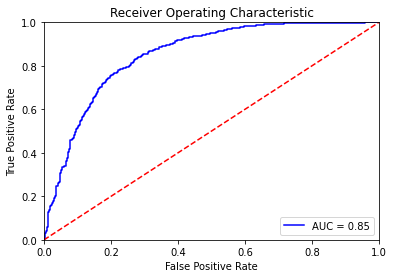

In [18]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = log_class.predict_proba(X_test_nt)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc_logfs = metrics.auc(fpr, tpr)
roc_auc = []
roc_auc.append(round(roc_auc_logfs, 2))

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_logfs)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

*The Logistic Regression model gives good prediction on whether a song is a hit or not.*

## *K-Nearest Neighbor*
- Based on Euclidean distance - similar data points are close to each other, close to the mode of a particular K label for classification
- Number of K labels chosen to reduce the number of errors while maintaining prediction accuracy

## Find optimal number of K neighbors using Elbow Method

Text(0, 0.5, 'Error Rate')

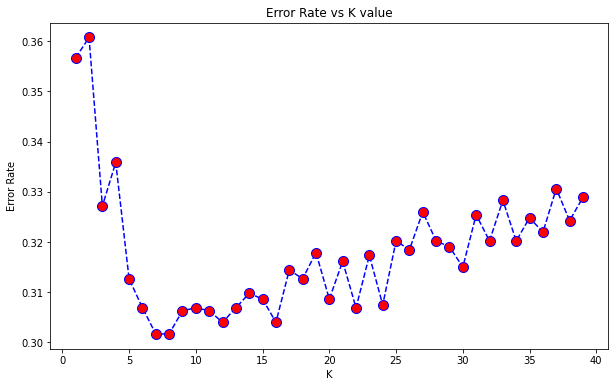

In [19]:
from sklearn.neighbors import KNeighborsClassifier
error_rate = []

for i in range(1,40):
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(X_train_nt, y_train)
  pred_i = knn.predict(X_test_nt)
  error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize = (10,6))
plt.plot(range(1,40), error_rate, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate vs K value')
plt.xlabel('K')
plt.ylabel('Error Rate')

K = 7 gives the lowest Error Rate

## Train the K-Nearest Neighbor model on the Training set

In [20]:
knn_class = KNeighborsClassifier(n_neighbors = 7, metric = 'minkowski', p = 2)
knn_class.fit(X_train_nt, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

## Predict the Test set Result

In [21]:
y_pred_knn = knn_class.predict(X_test_nt)

## kNN k-folds Cross Validation

In [22]:
from sklearn.model_selection import cross_val_score
knn_acc = cross_val_score(estimator = knn_class, X = X_nt_sc, y = y, cv = 10, scoring = 'accuracy')
print('Accuracy Mean:', knn_acc.mean(), '\nAccuracy SD:', knn_acc.std())

cvacc.append(round(knn_acc.mean(), 4))
cvacc_std.append(round(knn_acc.std(), 4))

Accuracy Mean: 0.6881859938337633 
Accuracy SD: 0.014440717347497816


## Make the kNN Confusion Matrix

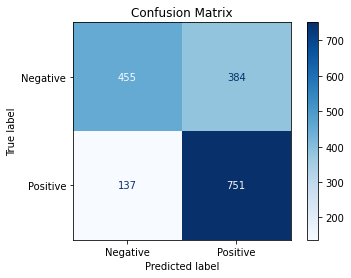

In [23]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix
class_names = np.array(['Negative', 'Positive'])
title = 'Confusion Matrix'
disp = plot_confusion_matrix(knn_class, X_test_nt, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             values_format='d')
disp.ax_.set_title(title)
plt.show()

In [24]:
# ROC AUC
from sklearn.metrics import roc_auc_score
roc_auc_knn = roc_auc_score(y_test, y_pred_knn)
roc_auc.append(round(roc_auc_knn, 2))
print('ROC-AUC: %.2f' % round(roc_auc_knn, 2))

ROC-AUC: 0.69


In [25]:
test_acc.append(round((accuracy_score(y_test, y_pred_knn)*100),2))
print('The accuracy score is {}%'.format(round((accuracy_score(y_test, y_pred_knn)*100),2)))

The accuracy score is 69.83%


## *Support Vector Machine - Linear*
- Finds a hyperplane in N-dimensional space (N = number of features) that classifies the data points
- Choose the hyperplane with maximum margin, i.e. maximum distance between data points of two classes
- Position and orientation of hyperplane are determined by support vectors, i.e. data points closest to the hyperplane

## Train the SVM model on the Training set

In [26]:
from sklearn.svm import SVC
svc_class = SVC(kernel = 'linear', random_state = 42)
svc_class.fit(X_train_nt, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

## Feature Selection

In [27]:
importance = np.abs(svc_class.coef_)

# Sum Coef's for Key (Categorical)
feat_key = np.array(importance[0,0:12].sum())
# Sum Coef's for Time_Signature (Categorical)
feat_time = np.array(importance[0,12:16].sum())
# Sum Coef's for Sections (Categorical)
feat_sec = np.array(importance[0,16:67].sum())

feat_rest = np.array(importance[0,67:])

# Gather coef values for Key, Time Signature, Sections, Artists, and rest of features
feat_hits = np.append(feat_key, feat_time)
feat_hits = np.append(feat_hits, feat_sec)
feat_hits = np.append(feat_hits, feat_rest)

feat_sig = pd.DataFrame(zip(feat_nt, feat_hits))
feat_sig.columns = ['Feature', 'Coef']
feat_sig = feat_sig.sort_values('Coef', ascending=False)
feat_sig = feat_sig.reset_index(drop=True)
feat_sig.index += 1 
feat_sig

,Feature,Coef
1,Sections,2.709490
2,Instrumentalness,0.923259
3,Speechiness,0.812102
4,Danceability,0.618564
5,Acousticness,0.501912
6,Duration_ms,0.416857
7,Loudness,0.364041
8,Key,0.243036
9,Time_Sig,0.185225
10,Valence,0.156110


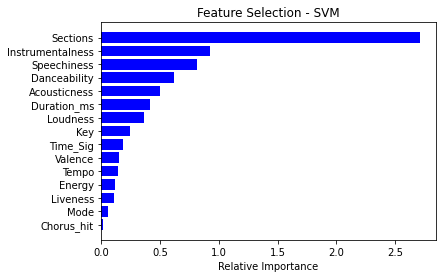

In [28]:
indices = np.argsort(feat_hits)
plt.title('Feature Selection - SVM')
plt.barh(range(len(indices)), feat_hits[indices], color='b', align='center')
plt.yticks(range(len(indices)), np.array(feat_nt)[indices])
plt.xlabel('Relative Importance')

plt.show()

Keep all Features. Eliminating features does not improve the accuracy score.

## Predict the Test set Result

In [29]:
y_pred_svc = svc_class.predict(X_test_nt)

## SVM k-folds Cross Validation

In [30]:
from sklearn.model_selection import cross_val_score
svc_acc = cross_val_score(estimator = svc_class, X = X_nt_sc, y = y, cv = 10)
print('Accuracy Mean:', svc_acc.mean(), '\nAccuracy SD:', svc_acc.std())

cvacc.append(round(svc_acc.mean(), 4))
cvacc_std.append(round(svc_acc.std(), 4))

Accuracy Mean: 0.7718555338828416 
Accuracy SD: 0.013297287895895111


## Make the SVM Confusion Matrix

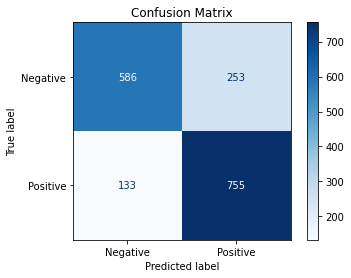

In [31]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix
class_names = np.array(['Negative', 'Positive'])
title = 'Confusion Matrix'
disp = plot_confusion_matrix(svc_class, X_test_nt, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             values_format='d')
disp.ax_.set_title(title)
plt.show()

In [32]:
# ROC AUC
roc_auc_svc = roc_auc_score(y_test, y_pred_svc)
roc_auc.append(round(roc_auc_svc, 2))
print('ROC-AUC: %.2f' % round(roc_auc_svc, 2))

ROC-AUC: 0.77


In [33]:
test_acc.append(round((accuracy_score(y_test, y_pred_svc)*100),2))
print('The accuracy score is {}%'.format(round((accuracy_score(y_test, y_pred_svc)*100),2)))

The accuracy score is 77.65%


The SVM model accuracy is good

## *Kernel SVM*
- Support Vector Machine with a kernel to separate each data point by projecting it into a higher dimension
- Kernel computes dot product of two vectors x and y in a high dimensional feature space
- Example - RBF kernel: *K(X$_{1}$,X$_{2}$) = exp(-$\gamma$||X$_{1}$ - X$_{2}$||$^{2}$)*, where ||X$_{1}$ - X$_{2}$|| is the Eucleadian distance between X$_{1}$ and X$_{2}$.

## Train the Kernel SVM model on the Training set

In [34]:
from sklearn.svm import SVC
ksvc_class = SVC(kernel = 'rbf', random_state = 42)
ksvc_class.fit(X_train_nt, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

## Predict the Test set Result

In [35]:
y_pred_ksvc = ksvc_class.predict(X_test_nt)

## Kernel SVM k-folds Cross Validation

In [36]:
from sklearn.model_selection import cross_val_score
ksvc_acc = cross_val_score(estimator = ksvc_class, X = X_nt_sc, y = y, cv = 10)
print('Accuracy Mean:', ksvc_acc.mean(), '\nAccuracy SD:', ksvc_acc.std())

cvacc.append(round(ksvc_acc.mean(), 4))
cvacc_std.append(round(ksvc_acc.std(), 4))

Accuracy Mean: 0.7775003670378993 
Accuracy SD: 0.013865426983749625


## Make the Kernel SVM Confusion Matrix

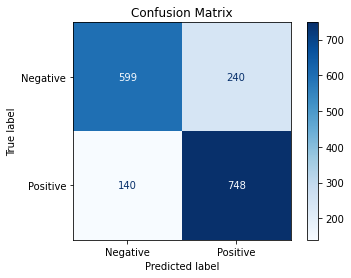

In [37]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix
class_names = np.array(['Negative', 'Positive'])
title = 'Confusion Matrix'
disp = plot_confusion_matrix(ksvc_class, X_test_nt, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             values_format='d')
disp.ax_.set_title(title)
plt.show()

In [38]:
# ROC AUC
roc_auc_ksvc = roc_auc_score(y_test, y_pred_ksvc)
roc_auc.append(round(roc_auc_ksvc, 2))
print('ROC-AUC: %.2f' % round(roc_auc_ksvc, 2))

ROC-AUC: 0.78


In [39]:
test_acc.append(round((accuracy_score(y_test, y_pred_ksvc)*100),2))
print('The accuracy score is {}%'.format(round((accuracy_score(y_test, y_pred_ksvc)*100),2)))

The accuracy score is 78.0%


The Kernel-SVM model accuracy is good

## *Naive-Bayes*
- Based on Bayes Theorem: $$ P(A|B) = \frac{P(B|A)P(A)}{P(B)} $$ where P(A|B) is the probability of **A** happening, given that **B** has occurred. **A** is the hypothesis and **B** is the evidence.

- *Naive:* Features are independent of each other
- *Gaussian NB classifier:* Continuous values of features are assumed to have a Normal distribution

## Train the Naive-Bayes model on the Training set

In [40]:
from sklearn.naive_bayes import GaussianNB
nb_class = GaussianNB()
nb_class.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

## Predict the Test set Result

In [41]:
y_pred_nb = nb_class.predict(X_test)

## Naive-Bayes k-folds Cross Validation

In [42]:
from sklearn.model_selection import cross_val_score
nb_acc = cross_val_score(estimator = nb_class, X = X, y = y, cv = 10)
print('Accuracy Mean:', nb_acc.mean(), '\nAccuracy SD:', nb_acc.std())

cvacc.append(round(nb_acc.mean(), 4))
cvacc_std.append(round(nb_acc.std(), 4))

Accuracy Mean: 0.641721093143732 
Accuracy SD: 0.015414889717838793


## Make the Naive-Bayes Confusion Matrix

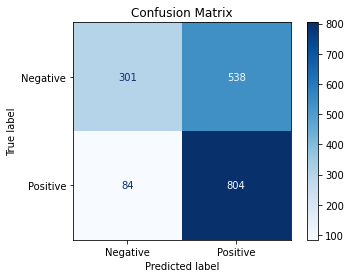

In [43]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix
class_names = np.array(['Negative', 'Positive'])
title = 'Confusion Matrix'
disp = plot_confusion_matrix(nb_class, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             values_format='d')
disp.ax_.set_title(title)
plt.show()

In [44]:
# ROC AUC
roc_auc_nb = roc_auc_score(y_test, y_pred_nb)
roc_auc.append(round(roc_auc_nb, 2))
print('ROC-AUC: %.2f' % round(roc_auc_nb, 2))

ROC-AUC: 0.63


In [45]:
test_acc.append(round((accuracy_score(y_test, y_pred_nb)*100),2))
print('The accuracy score is {}%'.format(round((accuracy_score(y_test, y_pred_nb)*100),2)))

The accuracy score is 63.98%


## *Multilayer Perceptron*
- Consists of linear layers (combination of neurons)
- *Makeup:* input layer - one or more hidden layers - output layer
- Fully connected layers - units in a layer are connected to all units in previous layer
- Units are independent of each other and have unique set of weights
- Loss function is calculated and backpropagated to adjust weights
- Goal is to minimize loss and stop when optimal minimization reached to avoid overfitting

In [46]:
from sklearn.model_selection import train_test_split

# Split the Training and Test sets
X_train_mlp, X_test_mlp, y_train, y_test = train_test_split(X_nt, y, test_size = 0.2, random_state = 42)

# Feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_mlp = sc.fit_transform(X_train_mlp)
X_test_mlp = sc.transform(X_test_mlp)

# Split the Training set to 70% Training and 30% Validation holdout
X_train_mlp_70, X_train_mlp_30, y_train_70, y_train_30 = train_test_split(X_train_mlp, y_train, test_size = 0.3, random_state = 42)

## Build the Multilayer Perceptron

In [47]:
import tensorflow as tf
# Initialize the MLP
mlp = tf.keras.models.Sequential()

# Add the input layer and the first hidden layer
mlp.add(tf.keras.layers.Dense(units=6, activation='relu'))

# Add the second hidden layer
mlp.add(tf.keras.layers.Dense(units=6, activation='relu'))

# Add the output layer
mlp.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

## Train the Multilayer Perceptron

In [48]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

# Compile the MLP
mlp.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Simple early stopping to prevent overfitting - go another 200 epochs to check for additional improvement
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
# Save best model accuracy
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Train the MLP on the Training set
history = mlp.fit(X_train_mlp_70, y_train_70, validation_data=(X_train_mlp_30, y_train_30), epochs=4000, verbose=0, callbacks=[es, mc])

# Load the saved model
saved_model = load_model('best_model.h5')

# Evaluate the model
_, acc_train = saved_model.evaluate(X_train_mlp_70, y_train_70, verbose=0)
_, acc_test = saved_model.evaluate(X_test_mlp, y_test, verbose=0)

cvacc.append(round(acc_train, 4))
cvacc_std.append(None)
print('Train: %.3f, Test: %.3f' % (acc_train, acc_test))


Epoch 00001: val_accuracy improved from -inf to 0.60072, saving model to best_model.h5

Epoch 00002: val_accuracy improved from 0.60072 to 0.64837, saving model to best_model.h5

Epoch 00003: val_accuracy improved from 0.64837 to 0.69481, saving model to best_model.h5

Epoch 00004: val_accuracy improved from 0.69481 to 0.72075, saving model to best_model.h5

Epoch 00005: val_accuracy improved from 0.72075 to 0.73221, saving model to best_model.h5

Epoch 00006: val_accuracy improved from 0.73221 to 0.74246, saving model to best_model.h5

Epoch 00007: val_accuracy improved from 0.74246 to 0.74729, saving model to best_model.h5

Epoch 00008: val_accuracy improved from 0.74729 to 0.75332, saving model to best_model.h5

Epoch 00009: val_accuracy improved from 0.75332 to 0.75513, saving model to best_model.h5

Epoch 00010: val_accuracy improved from 0.75513 to 0.76297, saving model to best_model.h5

Epoch 00011: val_accuracy improved from 0.76297 to 0.76659, saving model to best_model.h5

E

## Predict the Test set result

In [49]:
y_pred_mlp = saved_model.predict(X_test_mlp)
y_prcl_mlp = (y_pred_mlp > 0.5).astype('int32')

# reduce to 1d array
y_mlp_probs = y_pred_mlp[:, 0]
y_mlp_class = y_prcl_mlp[:, 0]

## Calculate Precision, Recall, F1-score, ROC-AUC

In [50]:
from sklearn.metrics import precision_score, recall_score, f1_score

# precision tp / (tp + fp)
precision_mlp = round(precision_score(y_test, y_mlp_class), 2)

# recall: tp / (tp + fn)
recall_mlp = round(recall_score(y_test, y_mlp_class), 2)

# f1: 2 tp / (2 tp + fp + fn)
f1_mlp = round(f1_score(y_test, y_mlp_class), 2)
 
# ROC AUC
roc_auc_mlp = roc_auc_score(y_test, y_mlp_probs)
roc_auc.append(round(roc_auc_mlp, 2))
print('ROC-AUC: %.2f' % round(roc_auc_mlp, 2))

ROC-AUC: 0.83


## Make the Confusion Matrix

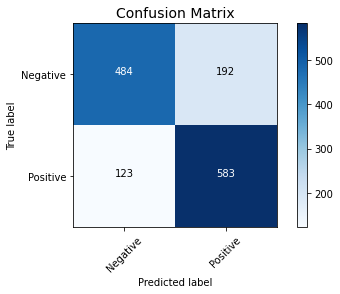

In [51]:
# Customized confusion matrix function for neural network
from sklearn.metrics import confusion_matrix, accuracy_score
import itertools

# Create a confusion matrix
def nn_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

labels = ['Negative', 'Positive']

cnf_matrix = confusion_matrix(y_test, y_mlp_class)
nn_confusion_matrix(cnf_matrix, labels, title="Confusion Matrix")

In [52]:
test_acc.append(round((accuracy_score(y_test, y_mlp_class)*100),2))
print('The accuracy score is {}%'.format(round((accuracy_score(y_test, y_mlp_class)*100),2)))

The accuracy score is 77.21%


## ***Tree-Based Algorithms***

## *Decision Tree Classification*
- Consists of root node (has children), internal node (has both parent and children), leaf node (has parent)
- Max_depth - *Number of levels:* the more levels, the more complex the model, which can result in overfitting the training data with high test error
- Information gain measures node purity, or how clever a node can split items

## Train the Decision Tree Classification model on the Training set

In [53]:
from sklearn.tree import DecisionTreeClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
dt_class = DecisionTreeClassifier(criterion = 'entropy', random_state = 42)
dt_class.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

## Predict the Test set Result

In [54]:
y_pred_dt = dt_class.predict(X_test)

## Decision Tree k-folds Cross Validation

In [55]:
from sklearn.model_selection import cross_val_score
dt_acc = cross_val_score(estimator = dt_class, X = X, y = y, cv = 10)
print('Accuracy Mean:', dt_acc.mean(), '\nAccuracy SD:', dt_acc.std())

cvacc.append(round(dt_acc.mean(), 4))
cvacc_std.append(round(dt_acc.std(), 4))

Accuracy Mean: 0.7245195998238217 
Accuracy SD: 0.012268503336810262


## Make the Decision Tree Confusion Matrix

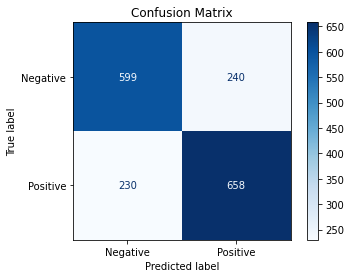

In [56]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix
class_names = np.array(['Negative', 'Positive'])
title = 'Confusion Matrix'
disp = plot_confusion_matrix(dt_class, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             values_format='d')
disp.ax_.set_title(title)
plt.show()

In [57]:
test_acc.append(round((accuracy_score(y_test, y_pred_dt)*100),2))
print('The accuracy score is {}%'.format(round((accuracy_score(y_test, y_pred_dt)*100),2)))

The accuracy score is 72.79%


Let's go to the Random Forest and XGBoost models to see if we can get better accuracy.

## Decision Tree ROC Curve

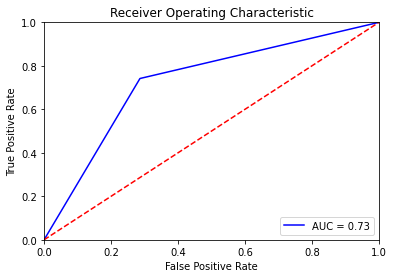

In [58]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = dt_class.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc_dt = metrics.auc(fpr, tpr)
roc_auc.append(round(roc_auc_dt, 2))

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_dt)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Feature Importance

In [59]:
feat_dt = dt_class.feature_importances_

feat_importances = pd.DataFrame(zip(feat_tree, feat_dt))
feat_importances.columns = ['feature', 'f_score']
feat_importances = feat_importances.sort_values('f_score', ascending=False)
feat_importances = feat_importances.reset_index(drop=True)
feat_importances.index += 1 
feat_importances

,feature,f_score
1,instrumentalness,0.176287
2,duration_ms,0.134338
3,acousticness,0.114026
4,danceability,0.096330
5,speechiness,0.092550
6,chorus_hit,0.063269
7,loudness,0.059052
8,valence,0.055385
9,tempo,0.054288
10,energy,0.047006


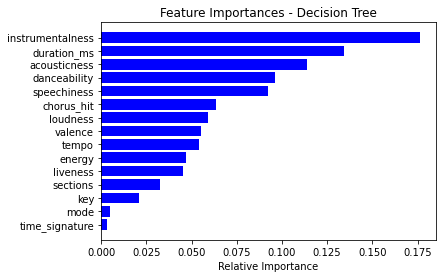

In [60]:
dt_importances = dt_class.feature_importances_
indices = np.argsort(dt_importances)

plt.title('Feature Importances - Decision Tree')
plt.barh(range(len(indices)), dt_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), np.array(feat_tree)[indices])
plt.xlabel('Relative Importance')

plt.show()

Instrumentalness, duration_ms, acousticness, danceability, and speechiness are the top drivers to predict hit songs in the Decision Tree model.

## *Random Forest Classification*
- Bagging/Bootstrapping technique - Random sampling of subset of data reduces bias and variance
- Ensemble method has multiple decision tree models run independently, then output is averaged/aggregated

## Train the Random Forest Classification model on the Training set

In [61]:
from sklearn.ensemble import RandomForestClassifier
rf_class = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
rf_class.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

## Predict the Test set Result

In [62]:
y_pred_rf = rf_class.predict(X_test)

## Random Forest k-folds Cross Validation

In [63]:
from sklearn.model_selection import cross_val_score
rf_acc = cross_val_score(estimator = rf_class, X = X, y = y, cv = 10)
print('Accuracy Mean:', rf_acc.mean(), '\nAccuracy SD:', rf_acc.std())

cvacc.append(round(rf_acc.mean(), 4))
cvacc_std.append(round(rf_acc.std(), 4))

Accuracy Mean: 0.783147507288324 
Accuracy SD: 0.015280120449037374


## Make the Random Forest Confusion Matrix

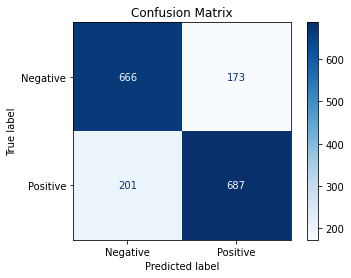

In [64]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix
class_names = np.array(['Negative', 'Positive'])
title = 'Confusion Matrix'
disp = plot_confusion_matrix(rf_class, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             values_format='d')
disp.ax_.set_title(title)
plt.show()

In [65]:
test_acc.append(round((accuracy_score(y_test, y_pred_rf)*100),2))
print('The accuracy score is {}%'.format(round((accuracy_score(y_test, y_pred_rf)*100),2)))

The accuracy score is 78.34%


Not surprisingly, Random Forest has a better accuracy than Decision Tree model and is overall the second-best model.

## Random Forest ROC Curve

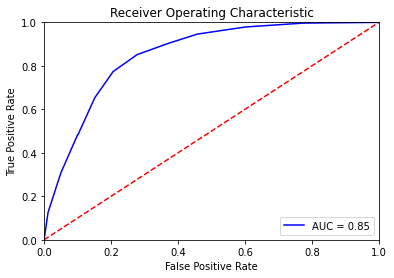

In [66]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = rf_class.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc_rf = metrics.auc(fpr, tpr)
roc_auc.append(round(roc_auc_rf, 2))

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_rf)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Feature Importance

In [67]:
feat_rf = rf_class.feature_importances_

feat_importances = pd.DataFrame(zip(feat_tree,feat_rf))
feat_importances.columns = ['feature','f_score']
feat_importances = feat_importances.sort_values('f_score', ascending=False)
feat_importances = feat_importances.reset_index(drop=True)
feat_importances.index += 1 
feat_importances

,feature,f_score
1,acousticness,0.129314
2,instrumentalness,0.117604
3,danceability,0.102216
4,duration_ms,0.099580
5,speechiness,0.085616
6,loudness,0.078419
7,valence,0.068359
8,liveness,0.060494
9,energy,0.058171
10,tempo,0.056482


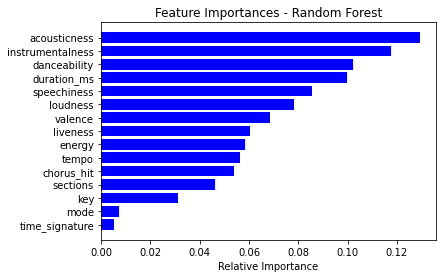

In [68]:
rf_importances = rf_class.feature_importances_
indices = np.argsort(rf_importances)

plt.title('Feature Importances - Random Forest')
plt.barh(range(len(indices)), rf_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), np.array(feat_tree)[indices])
plt.xlabel('Relative Importance')

plt.show()

Acousticness, instrumentalness, danceability, and duration_ms are the top drivers to predict if a song will be a hit in the Random Forest model.

## *XGBoost Classification*
- Builds sequential trees using parallel implementation by switching order of loops (1) to enumerate leaf nodes and (2) to calculate features
- Tree pruning - 'max-depth' parameter defined first then trees 'pruned' to improve computational performance
- Finds optimal split points in weighted datasets
- Built-in regularization via LASSO (L1) or Ridge (L2) to prevent overfitting
- Built-in cross validation

## Train the XGBoost Classification model on the Training set

In [69]:
from xgboost import XGBClassifier
xgb_class = XGBClassifier()
xgb_class.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

## Predict the Test set Result

In [70]:
y_pred_xgb = xgb_class.predict(X_test)

## XGBoost k-folds Cross Validation

In [71]:
from sklearn.model_selection import cross_val_score
xgb_acc = cross_val_score(estimator = xgb_class, X = X, y = y, cv = 10)
print('Accuracy Mean:', xgb_acc.mean(), '\nAccuracy SD:', xgb_acc.std())

cvacc.append(round(xgb_acc.mean(), 4))
cvacc_std.append(round(xgb_acc.std(), 4))

Accuracy Mean: 0.7995077497430735 
Accuracy SD: 0.006384019091061022


## Make the XGBoost Confusion Matrix

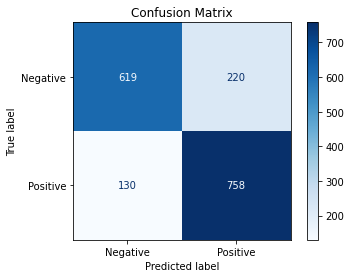

In [72]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix
class_names = np.array(['Negative', 'Positive'])
title = 'Confusion Matrix'
disp = plot_confusion_matrix(xgb_class, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             values_format='d')
disp.ax_.set_title(title)
plt.show()

In [73]:
test_acc.append(round((accuracy_score(y_test, y_pred_xgb)*100),2))
print('The accuracy score is {}%'.format(round((accuracy_score(y_test, y_pred_xgb)*100),2)))

The accuracy score is 79.73%


**XGBoost is overall the best model for prediction accuracy**

## XGBoost ROC Curve

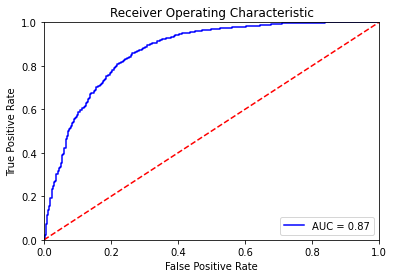

In [74]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = xgb_class.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc_xgb = metrics.auc(fpr, tpr)
roc_auc.append(round(roc_auc_xgb, 2))

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_xgb)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Feature Importance

In [75]:
feat_xgb = xgb_class.feature_importances_

feat_importances = pd.DataFrame(zip(feat_tree,feat_xgb))
feat_importances.columns = ['feature','f_score']
feat_importances = feat_importances.sort_values('f_score', ascending=False)
feat_importances = feat_importances.reset_index(drop=True)
feat_importances.index += 1 
feat_importances

,feature,f_score
1,instrumentalness,0.243383
2,duration_ms,0.120712
3,danceability,0.117933
4,acousticness,0.115867
5,speechiness,0.088271
6,loudness,0.047807
7,valence,0.045369
8,sections,0.042753
9,liveness,0.039120
10,time_signature,0.037742


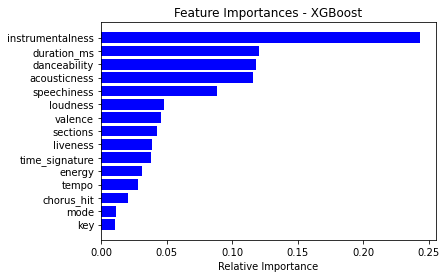

In [76]:
xgb_importances = xgb_class.feature_importances_
indices = np.argsort(xgb_importances)

plt.title('Feature Importances - XGBoost')
plt.barh(range(len(indices)), xgb_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), np.array(feat_tree)[indices])
plt.xlabel('Relative Importance')

plt.show()

Similar to the Decision Tree and Random Forest models, instrumentalness, duration_ms, danceability, and acousticness are the top drivers to predict if a song will be a hit in the XGBoost model.

**XGBoost gives the best accuracy score out of all model predictions. Let's dig deeper into how key features contribute to XGBoost model accuracy.**

## SHAP Values
- SHAP (**SH**apely **A**dditive ex**P**lanations) values measure the impact of the order of features on model prediction by taking into account their interaction with other features
- Indicates not only which features are important, but also how each feature matters to model prediction; correlates level of feature value to target value
- Based on the [hallmark 2017 paper by Scott Lundberg and Su-In Lee](https://arxiv.org/pdf/1705.07874.pdf)

## SHAP Summary Plot for XGBoost
- Gives birds-eye view of feature importance and what is driving it
- Y-axis has feature names in order of importance from top to bottom based on the sum of SHAP value magnitudes
- Color shows if feature is high (red) or low (blue) for a particular dataset row (dot)
- Horizontal location shows if the effect of that value causes a higher or lower prediction

In [78]:
# pip install shap

     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394119 sha256=0bb45148189139454e0874630d0ecd2e9661672a65555a6b241a7ca0f76feefd
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


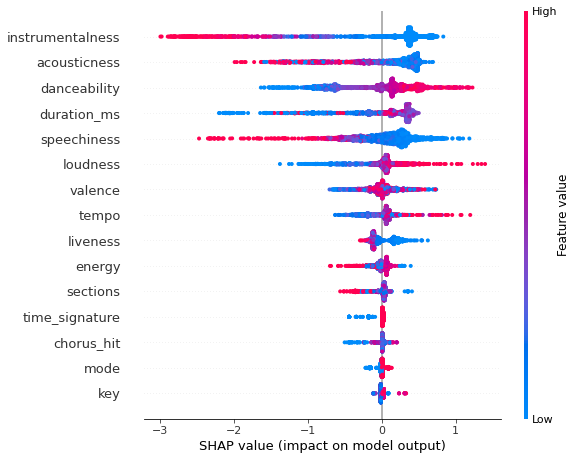

In [79]:
import shap
explainer = shap.TreeExplainer(xgb_class)
shap_values = explainer.shap_values(X_test, approximate=True)
X_test_df = pd.DataFrame(X_test)
X_test_df.columns = feat_tree
shap.summary_plot(shap_values, X_test_df)

### Sample Interpretations
- High values of instrumentalness, acousticness, and speechiness cause lower hit predictions
- High values of danceability, loudness, and tempo cause higher hit predictions
- Time_signature, chorus_hit, mode, and key do not affect hit predictions

## SHAP Dependence Contribution Plots
- Shows the distribution of a single feature and how this impacts prediction
- *Feature Interaction* - shows if the feature values in the distribution depend on the values of another feature (by color)
- Automatically selects another feature for coloring and effects of interaction

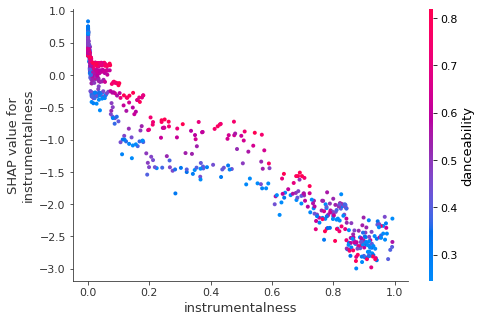

In [80]:
shap.dependence_plot('instrumentalness', shap_values, X_test_df)

### Interpretations
- The higher the instrumentalness (i.e. no vocals), the lower the model's prediction is for the song being a hit
- If the danceability is high (red dots), the model's prediction is higher for the song being a hit at low to mid-range instrumentalness scores (0.1 - 0.6); there is no effect of danceability on model prediction outside of this range

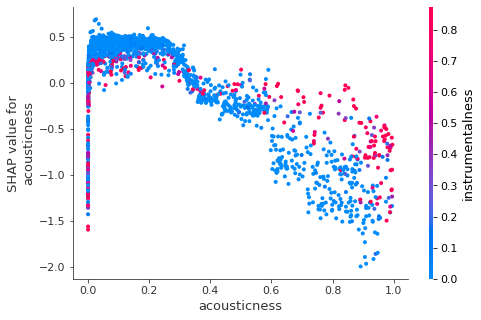

In [81]:
shap.dependence_plot('acousticness', shap_values, X_test_df)

### Interpretations
- Starting from acousticness = 0.2, the higher the acousticness, the lower the model's prediction is for the song being a hit
- If the instrumentalness is high (red dots), the model's prediction for the song being a hit is higher at high acousticness scores (0.7 - 1.0) (pure acoustic and no vocals songs)

## Map Predicted Hit Songs to Artists

In [82]:
track = []
artist = []
tempo = []
tempo = list(X_test[:,-5])
for i in range(0, len(dataset)):
    if dataset.iloc[i,-6] in tempo:
      track.append(dataset.iloc[i,0])
      artist.append(dataset.iloc[i,1])

## Sample Table of Predicted vs. Actual Hits - Test set (1,727 total) (in no particular order)

In [83]:
hits_log = pd.DataFrame(zip(track, artist, list(y_pred_log), list(y_test)))
hits_log.columns = ['Track', 'Artist', 'Predicted Hit','Actual Hit']
hits_log = hits_log.reset_index(drop=True)
hits_log.index += 1 
hits_log.head(25)

,Track,Artist,Predicted Hit,Actual Hit
1,Answering Machine,Rupert Holmes,1,1
2,Make It Real,The Jets,1,1
3,The Silver Ball - 2005 Digital Remaster,Harold Budd,1,1
4,Ridge Road Gravel,Norman Blake,0,0
5,Habaneras de Cadiz,Carlos Cano,1,1
6,Precious To Me,Phil Seymour,1,0
7,Tollkühn,Moebius,1,1
8,I'm Gonna Miss You,Kenny Loggins,0,1
9,When He Shines,Sheena Easton,0,1
10,Small World,Huey Lewis & The News,0,0


## Model Summary

In [84]:
model = ['Logistic-Feature Select', 'K-Nearest Neighbor', 'SVM', 'Kernel-SVM', 'Naive-Bayes', 'Multilayer Perceptron', 'Decision Tree', 'Random Forest', 'XGBoost']
sum_stats = pd.DataFrame(zip(model, cvacc, cvacc_std, test_acc, roc_auc))
sum_stats.columns = ['Model', 'Cross Validation Score', 'CV std dev', 'Test Accuracy (%)', 'ROC-AUC']
sum_stats = sum_stats.sort_values('Test Accuracy (%)', ascending=False)
sum_stats = sum_stats.reset_index(drop=True)
sum_stats.index += 1 
sum_stats

,Model,Cross Validation Score,CV std dev,Test Accuracy (%),ROC-AUC
1,XGBoost,0.7995,0.0064,79.73,0.87
2,Random Forest,0.7831,0.0153,78.34,0.85
3,Logistic-Feature Select,0.7745,0.0126,78.05,0.85
4,Kernel-SVM,0.7775,0.0139,78.00,0.78
5,SVM,0.7719,0.0133,77.65,0.77
6,Multilayer Perceptron,0.7924,NaN,77.21,0.83
7,Decision Tree,0.7245,0.0123,72.79,0.73
8,K-Nearest Neighbor,0.6882,0.0144,69.83,0.69
9,Naive-Bayes,0.6417,0.0154,63.98,0.63


### Evaluate Classification Reports for Top 6
- 0 = No hit
- 1 = Hit song

#### XGBoost

In [85]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.83      0.74      0.78       839
           1       0.78      0.85      0.81       888

    accuracy                           0.80      1727
   macro avg       0.80      0.80      0.80      1727
weighted avg       0.80      0.80      0.80      1727



#### Random Forest

In [86]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78       839
           1       0.80      0.77      0.79       888

    accuracy                           0.78      1727
   macro avg       0.78      0.78      0.78      1727
weighted avg       0.78      0.78      0.78      1727



#### Logistic Regression with Feature Selection

In [87]:
print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

           0       0.81      0.72      0.76       839
           1       0.76      0.84      0.80       888

    accuracy                           0.78      1727
   macro avg       0.78      0.78      0.78      1727
weighted avg       0.78      0.78      0.78      1727



#### Kernel SVM (RBF)

In [88]:
print(classification_report(y_test, y_pred_ksvc))

              precision    recall  f1-score   support

           0       0.81      0.71      0.76       839
           1       0.76      0.84      0.80       888

    accuracy                           0.78      1727
   macro avg       0.78      0.78      0.78      1727
weighted avg       0.78      0.78      0.78      1727



#### SVM

In [89]:
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.82      0.70      0.75       839
           1       0.75      0.85      0.80       888

    accuracy                           0.78      1727
   macro avg       0.78      0.77      0.77      1727
weighted avg       0.78      0.78      0.77      1727



#### Multilayer Perceptron

In [90]:
# Results for 1 = Survived
print('Precision: %.2f' % precision_mlp)
print('Recall: %.2f' % recall_mlp)
print('F1 score: %.2f' % f1_mlp)

Precision: 0.75
Recall: 0.83
F1 score: 0.79


## Conclusion

#### **The model that gave the best accuracy score, recall, and f1-score is XGBoost (79.73%) followed closely by Random Forest (78.34%). In the models where we can rank the Features, Instrumentalness, Acousticness, Danceability, and Speechiness are the most important features to determine whether a song is a hit. One can use these models and methods to determine if today's hot new songs will become hits.**